# Making a classification dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.DataFrame()

In [3]:
df['X1'] = [1,2,3,4,5,6,6,7,9,9]
df['X2'] = [5,3,6,8,1,9,5,8,9,2]
df['label'] = [1,1,0,1,0,1,0,1,0,0]
df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


<AxesSubplot:xlabel='X1', ylabel='X2'>

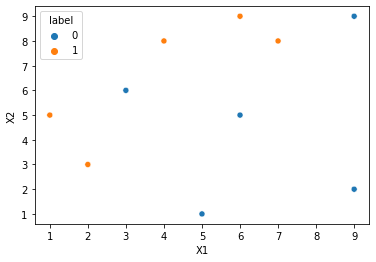

In [4]:
import seaborn as sns
sns.scatterplot(x=df['X1'],y=df['X2'],hue=df['label'])

This is a non-linear kind of data

# 1. Weights will be equally assigned

In [5]:
df['weights'] = 1/df.shape[0]
df

,X1,X2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


So, we have 10 records, so starting weight for each record is 0.1

# 2. Training the first Weak Learner on this dataset

Weak learner will be single node decision tree known as Decision Stump

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
dt1 = DecisionTreeClassifier(max_depth=1, random_state=42)

In [8]:
X = df.iloc[:,0:2].values
y = df.iloc[:,2].values
dt1.fit(X,y)

DecisionTreeClassifier(max_depth=1, random_state=42)

[Text(0.5, 0.75, 'X[0] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]')]

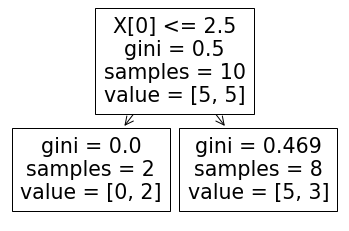

In [9]:
from sklearn.tree import plot_tree
plot_tree(dt1)

So, seems like the split is using the first feature, so it would be a vertical decision lin

Plotting the decison surface on the scatter plot

In [10]:
from mlxtend.plotting import plot_decision_regions

<AxesSubplot:>

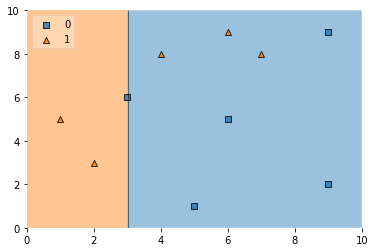

In [11]:
plot_decision_regions(X, y, clf=dt1, legend=2)

Clearly, there are so many wrong classifications here

Let us see the models prediction on the training data

In [12]:
df['y_pred'] = dt1.predict(X)
df

,X1,X2,label,weights,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,0
3,4,8,1,0.1,0
4,5,1,0,0.1,0
5,6,9,1,0.1,0
6,6,5,0,0.1,0
7,7,8,1,0.1,0
8,9,9,0,0.1,0
9,9,2,0,0.1,0


In total model have done 3 misclassifications

# 3. Calculating Model Weight 

Model weight will be the value of how much say of this model will be in the final prediction

Finding the weighted error rate, we need to add the weights where label is not equal to the y_pred

Here, error = 0.1+0.1+0.1 = 0.3

In [13]:
error = 0
for index,row in df.iterrows():
    if row["label"] != row["y_pred"]:
        error = error + row["weights"]
error

0.30000000000000004

In [14]:
def calculate_model_weight(error):

  return 0.5*np.log((1-error)/(error))

In [15]:
alpha1 = calculate_model_weight(error)
alpha1

0.4236489301936017

# 4. Updated weights

Using alpha1 we are going to calculate the updated weights i.e. the weights of correctly classified points will decrease and weights of incorrectly classified points will increase

In [16]:
def update_row_weights(row,alpha=alpha1):
    if row['label'] == row['y_pred']:
        return row['weights'] * np.exp(-alpha)
    else:
        return row['weights'] * np.exp(alpha)

In [17]:
df['updated_weights'] = df.apply(update_row_weights,axis=1)
df

,X1,X2,label,weights,y_pred,updated_weights
0,1,5,1,0.1,1,0.065465
1,2,3,1,0.1,1,0.065465
2,3,6,0,0.1,0,0.065465
3,4,8,1,0.1,0,0.152753
4,5,1,0,0.1,0,0.065465
5,6,9,1,0.1,0,0.152753
6,6,5,0,0.1,0,0.065465
7,7,8,1,0.1,0,0.152753
8,9,9,0,0.1,0,0.065465
9,9,2,0,0.1,0,0.065465


In [18]:
df["updated_weights"].sum()

0.9165151389911681

The sum is not equal to 1, so we will need to normalize these weights

# 5. Updated Normalized weights

In [19]:
df['nomalized_weights'] = df['updated_weights']/df['updated_weights'].sum()
df

,X1,X2,label,weights,y_pred,updated_weights,nomalized_weights
0,1,5,1,0.1,1,0.065465,0.071429
1,2,3,1,0.1,1,0.065465,0.071429
2,3,6,0,0.1,0,0.065465,0.071429
3,4,8,1,0.1,0,0.152753,0.166667
4,5,1,0,0.1,0,0.065465,0.071429
5,6,9,1,0.1,0,0.152753,0.166667
6,6,5,0,0.1,0,0.065465,0.071429
7,7,8,1,0.1,0,0.152753,0.166667
8,9,9,0,0.1,0,0.065465,0.071429
9,9,2,0,0.1,0,0.065465,0.071429


In [20]:
df['nomalized_weights'].sum()

0.9999999999999999

# 6. Making Cumulative Range Columns

In [21]:
df['cumsum_upper'] = np.cumsum(df['nomalized_weights'])
df

,X1,X2,label,weights,y_pred,updated_weights,nomalized_weights,cumsum_upper
0,1,5,1,0.1,1,0.065465,0.071429,0.071429
1,2,3,1,0.1,1,0.065465,0.071429,0.142857
2,3,6,0,0.1,0,0.065465,0.071429,0.214286
3,4,8,1,0.1,0,0.152753,0.166667,0.380952
4,5,1,0,0.1,0,0.065465,0.071429,0.452381
5,6,9,1,0.1,0,0.152753,0.166667,0.619048
6,6,5,0,0.1,0,0.065465,0.071429,0.690476
7,7,8,1,0.1,0,0.152753,0.166667,0.857143
8,9,9,0,0.1,0,0.065465,0.071429,0.928571
9,9,2,0,0.1,0,0.065465,0.071429,1.000000


In [22]:
df['cumsum_lower'] = df['cumsum_upper'] - df['nomalized_weights']
df[['X1','X2','label','weights','y_pred','nomalized_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weights,y_pred,nomalized_weights,cumsum_lower,cumsum_upper
0,1,5,1,0.1,1,0.071429,0.000000,0.071429
1,2,3,1,0.1,1,0.071429,0.071429,0.142857
2,3,6,0,0.1,0,0.071429,0.142857,0.214286
3,4,8,1,0.1,0,0.166667,0.214286,0.380952
4,5,1,0,0.1,0,0.071429,0.380952,0.452381
5,6,9,1,0.1,0,0.166667,0.452381,0.619048
6,6,5,0,0.1,0,0.071429,0.619048,0.690476
7,7,8,1,0.1,0,0.166667,0.690476,0.857143
8,9,9,0,0.1,0,0.071429,0.857143,0.928571
9,9,2,0,0.1,0,0.071429,0.928571,1.000000


# 7. The Upsampling step

Where we make a new dataset which will also be having the same number of records.
So, we will generate 10 random numbers between 0 and 1 and then choose those rows where these numbers lies.

(between cumsum_lower and cumsum_upper)

This numpy function generates random number between 0 and 1

In [23]:
np.random.random()

0.6563343923154864

We will just select the indices of those rows into a list

In [24]:
def create_new_dataset(df):
    indices = []

    for i in range(df.shape[0]):
        a = np.random.random()
        for index,row in df.iterrows():
            if row['cumsum_upper'] > a and a > row['cumsum_lower']:
                indices.append(index)
    return indices

In [25]:
index_values = create_new_dataset(df)

index_values

[3, 6, 1, 9, 3, 5, 2, 3, 0, 3]

So, we can see some index columns are being repeated which was incorrectly classified earlier.

So, the new dataset is ready to be used for the next weak learner

In [26]:
second_df = df.iloc[index_values,[0,1,2,3]]
second_df

,X1,X2,label,weights
3,4,8,1,0.1
6,6,5,0,0.1
1,2,3,1,0.1
9,9,2,0,0.1
3,4,8,1,0.1
5,6,9,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
0,1,5,1,0.1
3,4,8,1,0.1


Now, notice again the weights will be 0.1 as we have already done the upsampling (or boosting)

# 8. Second Decision Tree

Using this dataset to train Second Decision Stump

[Text(0.5, 0.75, 'X[1] <= 7.0\ngini = 0.42\nsamples = 10\nvalue = [3, 7]'),
 Text(0.25, 0.25, 'gini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]')]

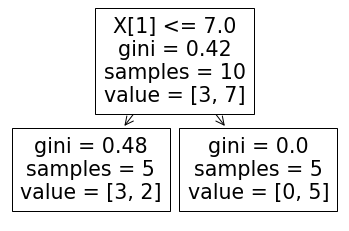

In [27]:
dt2 = DecisionTreeClassifier(max_depth=1, random_state=42)
X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values
dt2.fit(X,y)
plot_tree(dt2)

<AxesSubplot:>

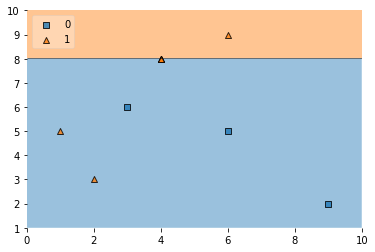

In [28]:
plot_decision_regions(X, y, clf=dt2, legend=2)

In [29]:
second_df['y_pred'] = dt2.predict(X)
second_df

,X1,X2,label,weights,y_pred
3,4,8,1,0.1,1
6,6,5,0,0.1,0
1,2,3,1,0.1,0
9,9,2,0,0.1,0
3,4,8,1,0.1,1
5,6,9,1,0.1,1
2,3,6,0,0.1,0
3,4,8,1,0.1,1
0,1,5,1,0.1,0
3,4,8,1,0.1,1


# 9. Again following the same logic 

In [30]:
error = 0
for index,row in second_df.iterrows():
    if row["label"] != row["y_pred"]:
        error = error + row["weights"]
error

0.2

In [31]:
alpha2 = calculate_model_weight(error)
alpha2

0.6931471805599453

In [32]:
def update_row_weights(row,alpha=alpha2):
    if row['label'] == row['y_pred']:
        return row['weights'] * np.exp(-alpha)
    else:
        return row['weights'] * np.exp(alpha)

In [33]:
second_df['updated_weights'] = second_df.apply(update_row_weights,axis=1)
second_df

,X1,X2,label,weights,y_pred,updated_weights
3,4,8,1,0.1,1,0.05
6,6,5,0,0.1,0,0.05
1,2,3,1,0.1,0,0.20
9,9,2,0,0.1,0,0.05
3,4,8,1,0.1,1,0.05
5,6,9,1,0.1,1,0.05
2,3,6,0,0.1,0,0.05
3,4,8,1,0.1,1,0.05
0,1,5,1,0.1,0,0.20
3,4,8,1,0.1,1,0.05


In [34]:
second_df['nomalized_weights'] = second_df['updated_weights']/second_df['updated_weights'].sum()
second_df

,X1,X2,label,weights,y_pred,updated_weights,nomalized_weights
3,4,8,1,0.1,1,0.05,0.0625
6,6,5,0,0.1,0,0.05,0.0625
1,2,3,1,0.1,0,0.20,0.2500
9,9,2,0,0.1,0,0.05,0.0625
3,4,8,1,0.1,1,0.05,0.0625
5,6,9,1,0.1,1,0.05,0.0625
2,3,6,0,0.1,0,0.05,0.0625
3,4,8,1,0.1,1,0.05,0.0625
0,1,5,1,0.1,0,0.20,0.2500
3,4,8,1,0.1,1,0.05,0.0625


In [35]:
second_df['nomalized_weights'].sum()

1.0

In [36]:
second_df['cumsum_upper'] = np.cumsum(second_df['nomalized_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['nomalized_weights']
second_df[['X1','X2','label','weights','y_pred','nomalized_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weights,y_pred,nomalized_weights,cumsum_lower,cumsum_upper
3,4,8,1,0.1,1,0.0625,0.0000,0.0625
6,6,5,0,0.1,0,0.0625,0.0625,0.1250
1,2,3,1,0.1,0,0.2500,0.1250,0.3750
9,9,2,0,0.1,0,0.0625,0.3750,0.4375
3,4,8,1,0.1,1,0.0625,0.4375,0.5000
5,6,9,1,0.1,1,0.0625,0.5000,0.5625
2,3,6,0,0.1,0,0.0625,0.5625,0.6250
3,4,8,1,0.1,1,0.0625,0.6250,0.6875
0,1,5,1,0.1,0,0.2500,0.6875,0.9375
3,4,8,1,0.1,1,0.0625,0.9375,1.0000


# 9. Similarly Third Dataset 

In [37]:
index_values = create_new_dataset(second_df)

In [38]:
third_df = second_df.iloc[index_values,[0,1,2,3]]
third_df

,X1,X2,label,weights
3,4,8,1,0.1
9,9,2,0,0.1
2,3,6,0,0.1
2,3,6,0,0.1
2,3,6,0,0.1
6,6,5,0,0.1
6,6,5,0,0.1
3,4,8,1,0.1
9,9,2,0,0.1
9,9,2,0,0.1


Training third decision tree on this dataset now

In [39]:
dt3 = DecisionTreeClassifier(max_depth=1, random_state=42)

X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values

dt3.fit(X,y)

DecisionTreeClassifier(max_depth=1, random_state=42)

<AxesSubplot:>

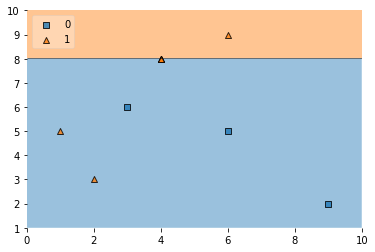

In [40]:
plot_decision_regions(X, y, clf=dt3, legend=2)

In [41]:
third_df['y_pred'] = dt3.predict(X)
third_df

,X1,X2,label,weights,y_pred
3,4,8,1,0.1,1
9,9,2,0,0.1,0
2,3,6,0,0.1,0
2,3,6,0,0.1,0
2,3,6,0,0.1,1
6,6,5,0,0.1,1
6,6,5,0,0.1,0
3,4,8,1,0.1,1
9,9,2,0,0.1,0
9,9,2,0,0.1,1


In [42]:
error = 0
for index,row in third_df.iterrows():
    if row["label"] != row["y_pred"]:
        error = error + row["weights"]
error

0.30000000000000004

In [43]:
alpha3 = calculate_model_weight(error)
alpha3

0.4236489301936017

This is a very bad model, but it is working good in predicting always bad which is a good thing,

So it deserves a high alpha value as it is able to wrongly predict 6 times out of 10.

But the sign will be negative

In [44]:
print(alpha1,alpha2,alpha3)

0.4236489301936017 0.6931471805599453 0.4236489301936017


# 10. Prediction Part

 Setting up a new query point to see how the overall ensemble is working

In [45]:
df

,X1,X2,label,weights,y_pred,updated_weights,nomalized_weights,cumsum_upper,cumsum_lower
0,1,5,1,0.1,1,0.065465,0.071429,0.071429,0.000000
1,2,3,1,0.1,1,0.065465,0.071429,0.142857,0.071429
2,3,6,0,0.1,0,0.065465,0.071429,0.214286,0.142857
3,4,8,1,0.1,0,0.152753,0.166667,0.380952,0.214286
4,5,1,0,0.1,0,0.065465,0.071429,0.452381,0.380952
5,6,9,1,0.1,0,0.152753,0.166667,0.619048,0.452381
6,6,5,0,0.1,0,0.065465,0.071429,0.690476,0.619048
7,7,8,1,0.1,0,0.152753,0.166667,0.857143,0.690476
8,9,9,0,0.1,0,0.065465,0.071429,0.928571,0.857143
9,9,2,0,0.1,0,0.065465,0.071429,1.000000,0.928571


1. Checking on First Query Point 

In original dataset when X1 = 1 and X2 = 5 the label should be 1

In [46]:
query1 = np.array([1,2]).reshape(1,2)

In [47]:
pred1 = dt1.predict(query1)
print("Prediction1",pred1)
pred2 = dt2.predict(query1)
print("Prediction2",pred2)
pred3 = dt3.predict(query1)
print("Prediction3",pred3)

Prediction1 [1]
Prediction2 [0]
Prediction3 [0]


Final Prediction

In [48]:
Final_pred = alpha1*(1) + alpha2*(-1) + alpha3*(-1)
Final_pred

-0.6931471805599453

In [49]:
np.sign(Final_pred)

-1.0

2. Checking on Second Query Point 

In original dataset when X1 = 9 and X2 = 2 the label should be 0

In [50]:
query2 = np.array([9,2]).reshape(1,2)

In [51]:
pred1 = dt1.predict(query1)
print("Prediction1",pred1)
pred2 = dt2.predict(query1)
print("Prediction2",pred2)
pred3 = dt3.predict(query1)
print("Prediction3",pred3)

Prediction1 [1]
Prediction2 [0]
Prediction3 [0]


In [52]:
Final_pred = alpha1*(1) + alpha2*(-1) + alpha3*(-1)
Final_pred

-0.6931471805599453

In [53]:
np.sign(Final_pred)

-1.0